# Graph

## 1. Graphe des Produits

**Objectif :** Trouver les produits fréquemment commandés ensemble

### 1.1 Construction du Graphe

In [149]:
# LOAD DATASET & PREPROCESSING

import pandas as pd

# Load datasets ###############################################################
df_products = pd.read_csv('../datasets/olist_products_dataset.csv')
df_order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')

# Preprocessing ################################################################
# Drop rows with missing values
df_products.dropna(inplace=True)
df_order_items.dropna(inplace=True)

# Drop columns that are not useful for the analysis 
df_products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)
df_order_items.drop(columns=['shipping_limit_date', 'freight_value', 'seller_id', 'price'], inplace=True)

# Drop duplicates
df_products.drop_duplicates(inplace=True)
df_order_items.drop_duplicates(inplace=True)

# Display df columns and number of rows
print("\n___ Products ___")
print("[ " + " | ".join(df_products.columns) + " ]")
print(f"Number of rows: {df_products.shape[0]}")

print("\n___ Order Items ___")
print("[ " + " | ".join(df_order_items.columns) + " ]")
print(f"Number of rows: {df_order_items.shape[0]}")



___ Products ___
[ product_id | product_category_name ]
Number of rows: 32340

___ Order Items ___
[ order_id | order_item_id | product_id ]
Number of rows: 112650


In [150]:
# CREATE GRAPH 
import networkx as nx



def create_graph(df_order_items, df_products, min_orders=30):
    # Create a graph
    G_products = nx.Graph()

    # Add nodes (products)
    products = df_order_items['product_id'].value_counts()
    filtered_products = products[products >= min_orders]
    G_products.add_nodes_from(filtered_products.index)
    # Add count attribute
    nx.set_node_attributes(G_products, dict(filtered_products), 'count')

    # Add product category attribute, if no category create one NONE
    product_categories = df_products.set_index('product_id')['product_category_name'].to_dict()
    for product in filtered_products.index:
        if product not in product_categories:
            product_categories[product] = 'NONE'
    nx.set_node_attributes(G_products, product_categories, 'category')

    # Add edges (products bought together)
    order_products = df_order_items.groupby('order_id')['product_id'].apply(list)
    for products in order_products:
        for i in range(len(products)):
            for j in range(i+1, len(products)):
                if products[i] in filtered_products.index and products[j] in filtered_products.index:
                    if G_products.has_edge(products[i], products[j]):
                        G_products[products[i]][products[j]]['weight'] += 1
                    else:
                        G_products.add_edge(products[i], products[j], weight=1)

    # Clean graph
    # Remove self loops
    G_products.remove_edges_from(nx.selfloop_edges(G_products))
    # Remove nodes with no edges
    G_products.remove_nodes_from(list(nx.isolates(G_products)))

    # Display graph info
    print("\n___ Graph ___")
    print(f"Number of nodes: {G_products.number_of_nodes()}")
    first_node = list(G_products.nodes)[0]
    print(f"Nodes attributes names: {G_products.nodes[first_node].keys()}")
    print(f"Number of edges: {G_products.number_of_edges()}")
    print(f"Edges attributes names: {G_products.edges[first_node, list(G_products.neighbors(first_node))[0]].keys()}")

    print(f"Average degree: {sum(dict(G_products.degree()).values())/G_products.number_of_nodes()}")
    print(f"Density: {nx.density(G_products)}")

    return G_products

# Create the graph
G_products = create_graph(df_order_items, df_products, min_orders=40)


___ Graph ___
Number of nodes: 71
Nodes attributes names: dict_keys(['count', 'category'])
Number of edges: 66
Edges attributes names: dict_keys(['weight'])
Average degree: 1.8591549295774648
Density: 0.026559356136820925


### 1.2 Détection des Communautés

Identifier des groupes de produits souvent commandés ensemble pour révéler des catégories naturelles.


___ Community detection ___
Number of communities: 23
Communities sizes: 9, 7, 6, 4, 4, 4, 3, 3, 3, 2, ...


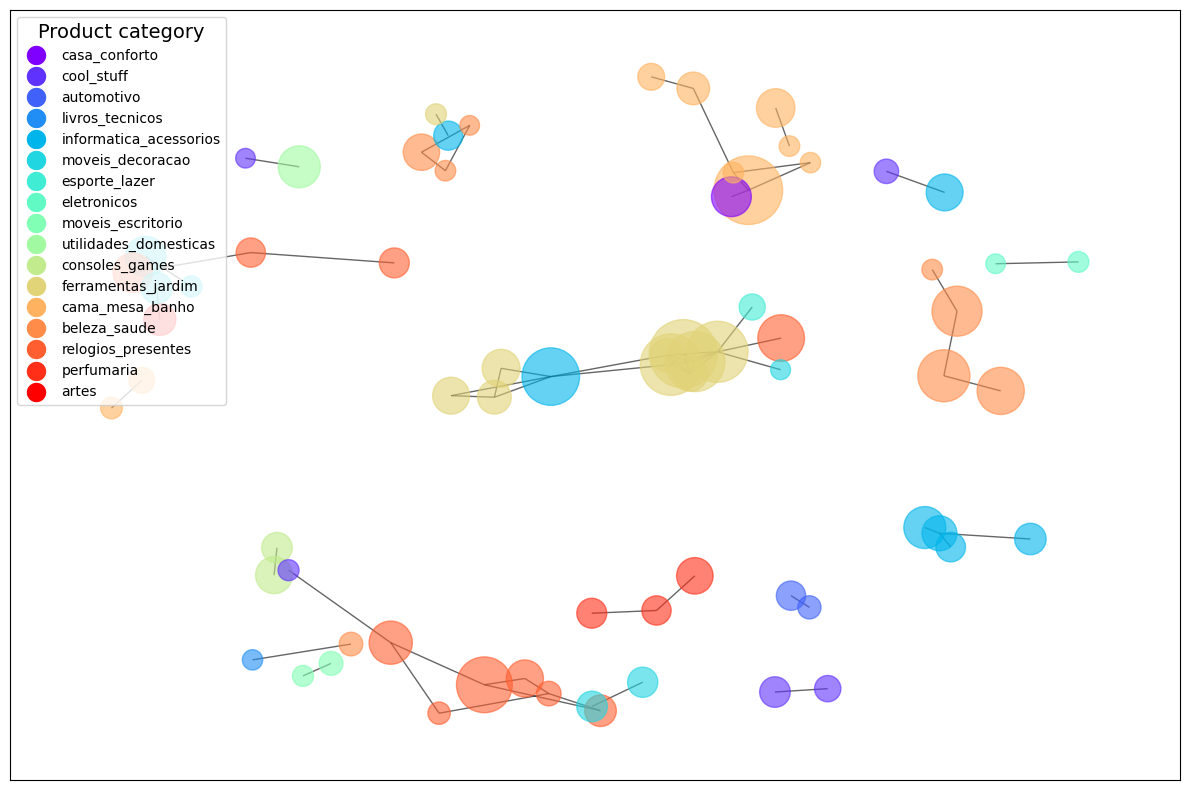

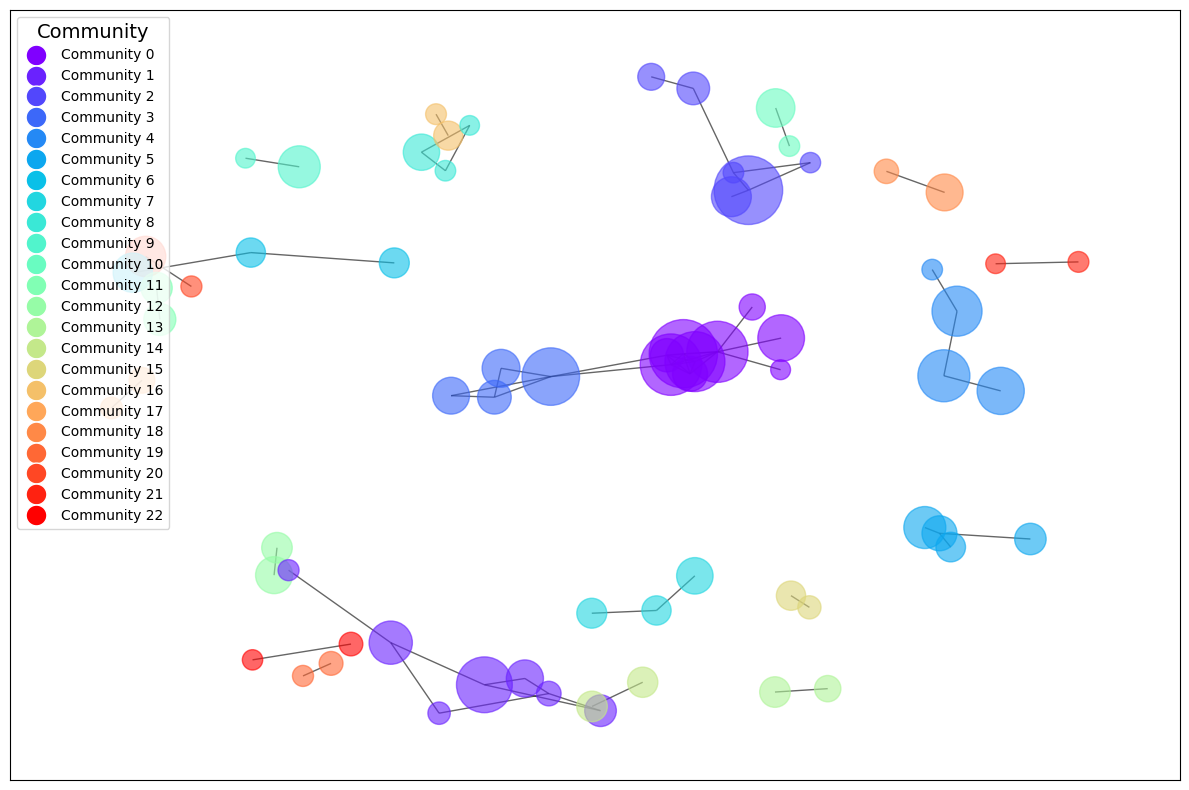

In [151]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Comunity detection (Louvain algorithm) #######################################
community = nx.community.louvain_communities(G_products, weight='weight')
community = sorted(community, key=len, reverse=True)
print("\n___ Community detection ___")
print(f"Number of communities: {len(community)}")
print(f"Communities sizes: {', '.join([str(len(c)) for c in community][:10])}, ...")

# Map each node to its community
node_community_map = {}
for i, comm in enumerate(community):
    for node in comm:
        node_community_map[node] = i

# Plot graphs ###################################################################
# Plot categories distribution
categories = list(set(nx.get_node_attributes(G_products, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G_products, k=0.3, iterations=50)
node_sizes = [G_products.nodes[n]['count'] * 5 for n in G_products.nodes]
node_colors = [category_colors[G_products.nodes[n]['category']] for n in G_products.nodes]
nx.draw_networkx(G_products, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.savefig('./images/graph-products-categories.png')
plt.show()

# Plot communities distribution
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(community)))
community_colors = dict(zip(range(len(community)), community_colors))
# Draw the graph
plt.figure(figsize=(12, 8))
node_sizes = [G_products.nodes[n]['count'] * 5 for n in G_products.nodes]
node_colors = [community_colors[node_community_map[n]] for n in G_products.nodes]
nx.draw_networkx(G_products, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"Community {i}", markerfacecolor=color, markersize=15)
                     for i, color in community_colors.items()]
plt.legend(handles=legend_elements, title="Community", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.savefig('./images/graph-products-communities.png')
plt.show()

### 1.3 Analyse de centralité

Identifier les produits les plus importants dans le réseau.
Permet de trouver les produits les plus populaires.


___ Graph ___
Number of nodes: 568
Nodes attributes names: dict_keys(['count', 'category'])
Number of edges: 519
Edges attributes names: dict_keys(['weight'])
Average degree: 1.8274647887323943
Density: 0.0032230419554363215


/tmp/ipykernel_487886/1996227679.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


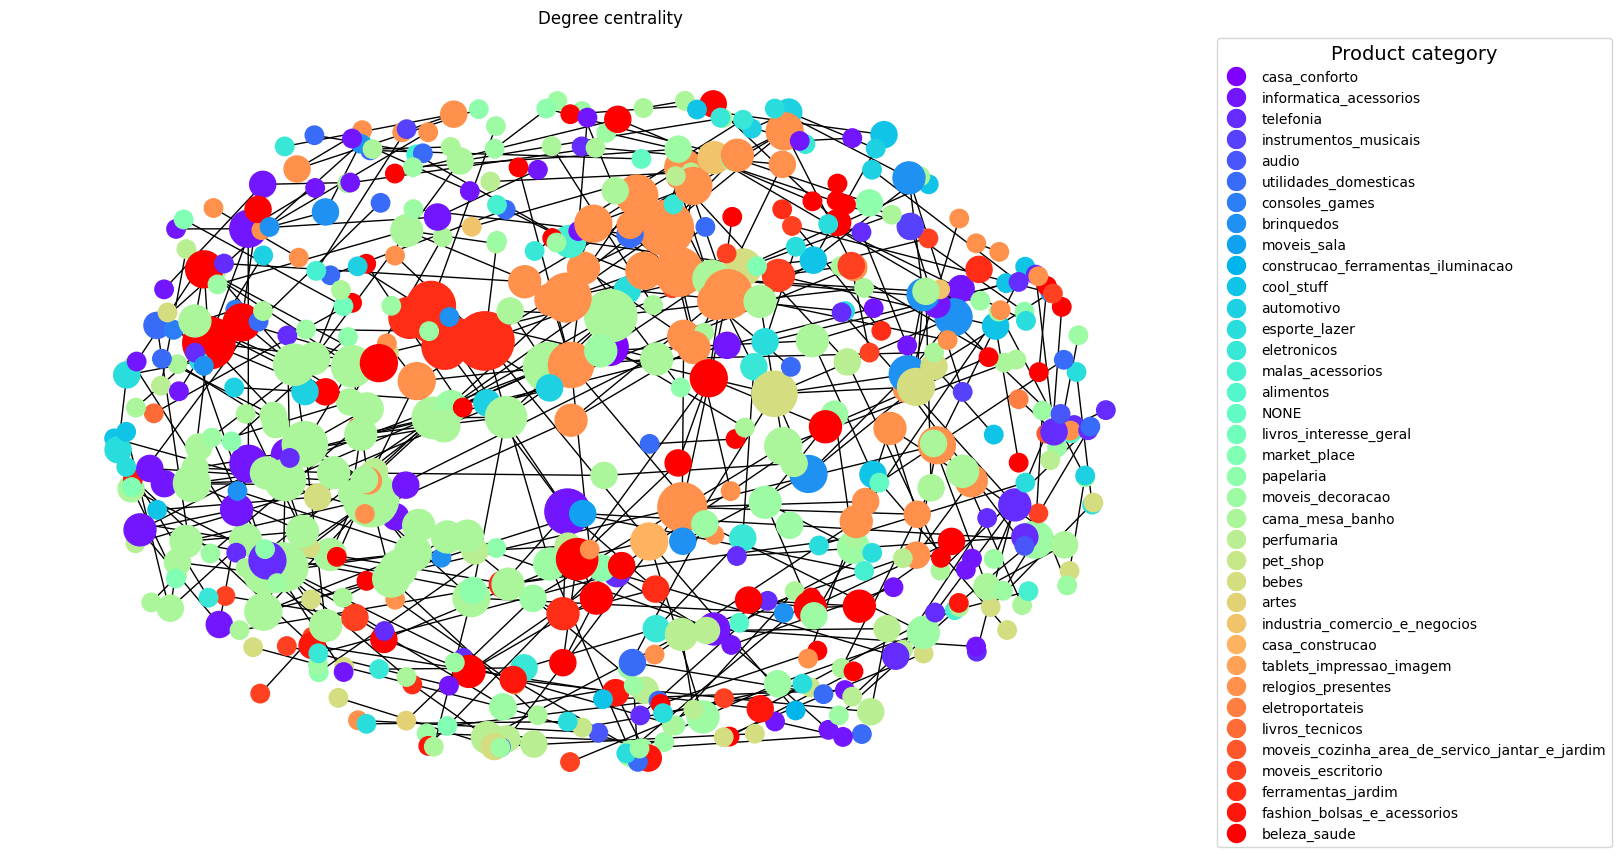

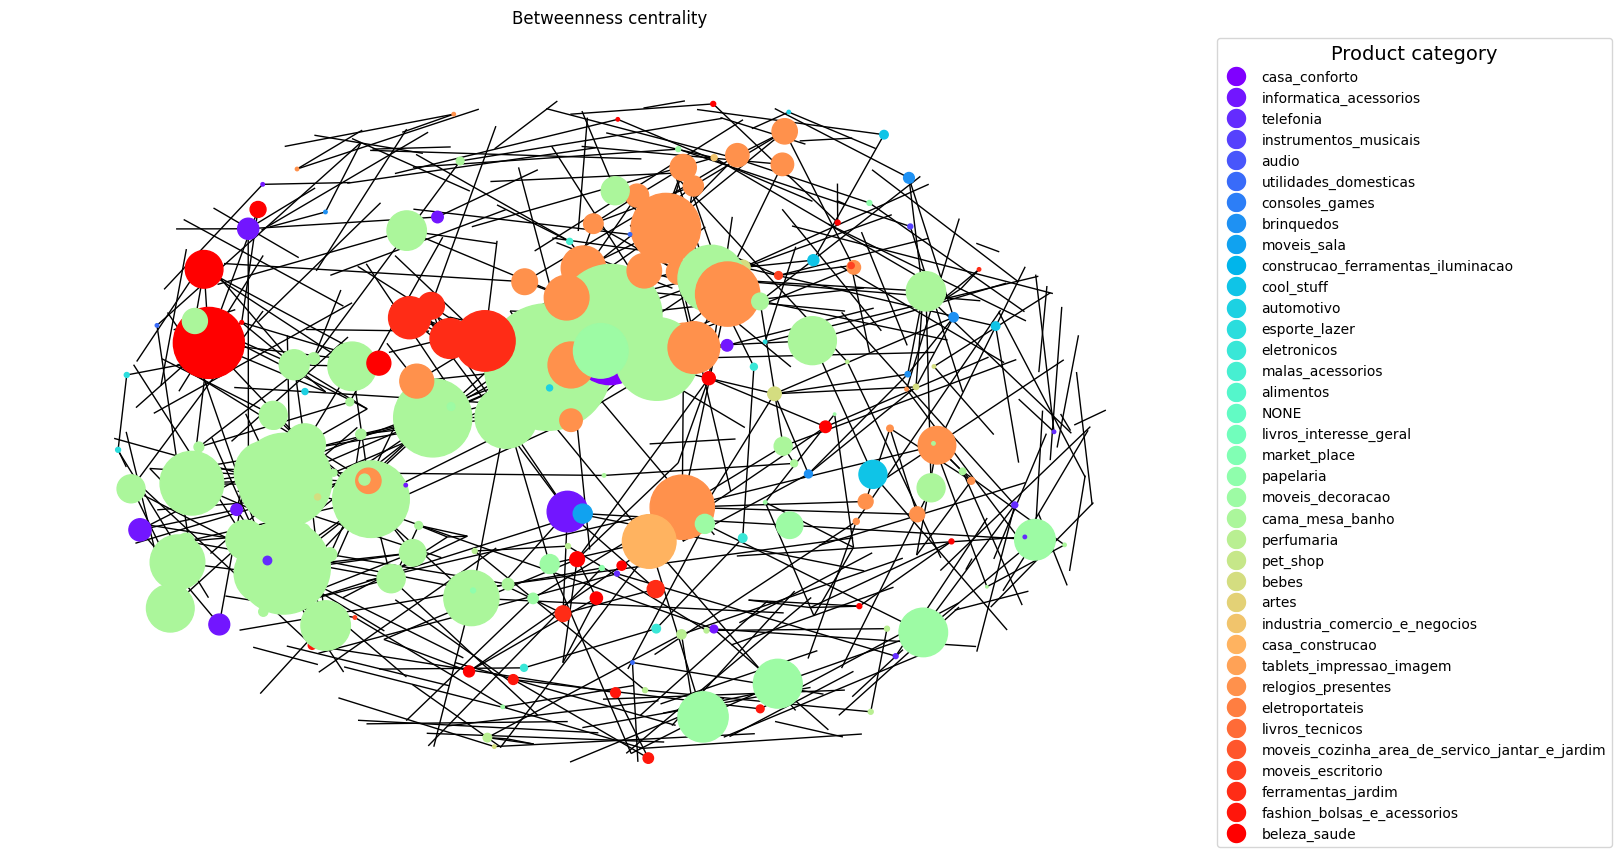

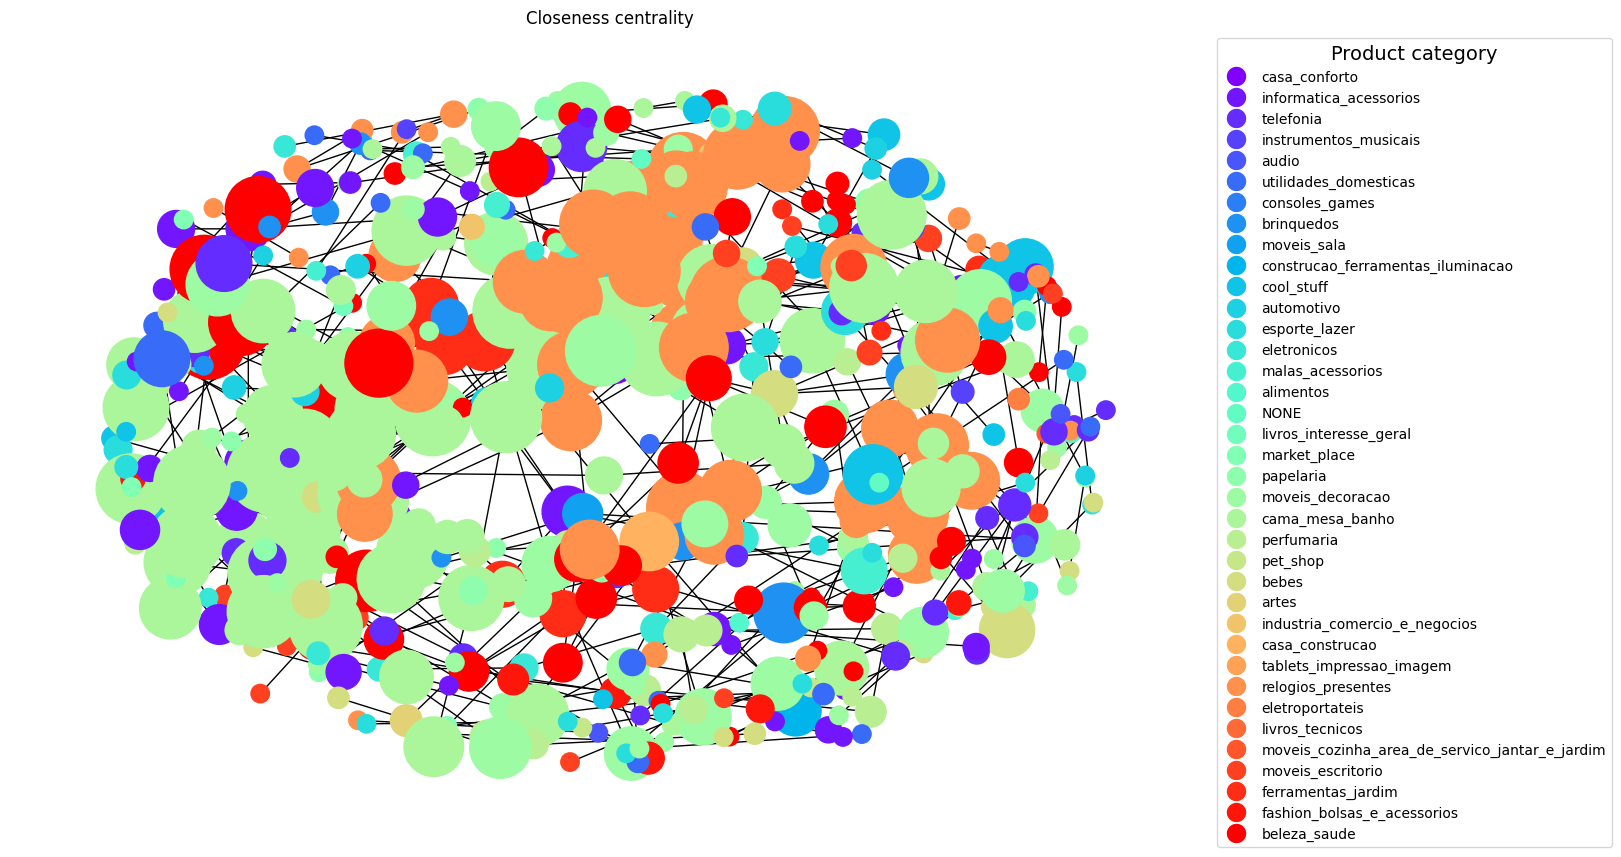

In [152]:
G_products = create_graph(df_order_items, df_products, min_orders=10)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G_products)
betweenness_centrality = nx.betweenness_centrality(G_products, weight='weight')
closeness_centrality = nx.closeness_centrality(G_products)


# Make category centrality
category_centrality = {}
for node in G_products.nodes:
    category = G_products.nodes[node]['category']
    if category not in category_centrality:
        category_centrality[category] = 0
    category_centrality[category] += degree_centrality[node]
    
# Ensure all categories have colors
categories = list(set(nx.get_node_attributes(G_products, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))

# Plot centrality measures
pos = nx.spring_layout(G_products, k=0.3, iterations=50)

def plot_centrality(centrality, title, scale_factor=10000):
    plt.figure(figsize=(12, 8))
    node_sizes = [centrality[n] * scale_factor for n in G_products.nodes]
    node_colors = [category_colors[G_products.nodes[n]['category']] for n in G_products.nodes]
    nx.draw(G_products, pos, node_size=node_sizes, node_color=node_colors, with_labels=False)
    plt.title(title)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                       for category, color in category_colors.items()]
    plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Plot centrality measures using the function
plot_centrality(degree_centrality, 'Degree centrality', scale_factor=100000)
plot_centrality(betweenness_centrality, 'Betweenness centrality', scale_factor=1000000)
plot_centrality(closeness_centrality, 'Closeness centrality', scale_factor=100000)


## 2. Graphe des Clients

**Objectif :** Identifier les clients qui ont des comportements similaires



### 2.1 Construction du Graphe

In [2]:
# DATA LOADING & PREPROCESSING ################################################

import pandas as pd

# Load datasets 
df_products = pd.read_csv('../datasets/olist_products_dataset.csv')
df_order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')
df_categories = pd.read_csv('../datasets/product_category_name_translation.csv')

# Preprocessing
# Drop columns that are not useful for the analysis
df_products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)
df_order_items.drop(columns=['shipping_limit_date', 'freight_value', 'seller_id', 'price'], inplace=True)
df_orders.drop(columns=['order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], inplace=True)
# Merge datasets order_items and orders on order_id
df_order_items = df_order_items.merge(df_orders, on='order_id')
df_order_items.drop(columns=['order_id'], inplace=True)
# Merge datasets products and categories on product_category_name
df_products = df_products.merge(df_categories, on='product_category_name')
df_products.drop(columns=['product_category_name'], inplace=True)
df_products.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)
del df_orders

# Drop duplicates
df_products.drop_duplicates(inplace=True)
df_order_items.drop_duplicates(inplace=True)

# Drop rows with missing values
df_products.dropna(inplace=True)
df_order_items.dropna(inplace=True)

# DISPLAY DATASETS ############################################################
print("\n___ Products ___")
print(f"Count: {df_products.shape[0]}")
print("[ " + " | ".join(df_products.columns) + " ]")

print("\n___ Order Items ___")
print(f"Count: {df_order_items.shape[0]}")
print("[ " + " | ".join(df_order_items.columns) + " ]")

print(f"\nNumber of unique products: {df_products['product_id'].nunique()}")
print(f"Number of unique customer: {df_order_items['customer_id'].nunique()}")



___ Products ___
Count: 32328
[ product_id | product_category ]

___ Order Items ___
Count: 112650
[ order_item_id | product_id | customer_id ]

Number of unique products: 32328
Number of unique customer: 98666


In [44]:
# CREATE GRAPH ################################################################

import networkx as nx

def create_graph(df_order_items, df_products, min_product_degree=10, min_customer_degree=10):
    # Create a graph
    G = nx.Graph()
    
    # nodes (products)
    products = df_order_items['product_id'].value_counts()
    products = products[products >= min_product_degree]
    products_categories = df_products.set_index('product_id')['product_category'].to_dict()
    G.add_nodes_from(products.index, bipartite='product')
    nx.set_node_attributes(G, products_categories, 'category')
    
    # nodes (customers)
    customers = df_order_items['customer_id'].value_counts()
    customers = customers[customers >= min_customer_degree]
    G.add_nodes_from(customers.index, bipartite='customer')
    nx.set_node_attributes(G, dict.fromkeys(customers.index, 'CLIENT'), 'category')
    
    # edges between customers and products
    customer_product = df_order_items.groupby(['customer_id', 'product_id']).size()
    for (customer, product), count in customer_product.items():
        if customer in G.nodes and product in G.nodes:
            G.add_edge(customer, product, weight=count**2)
    
    
    # Remove nodes with no category
    nodes_to_remove = [node for node in G.nodes if G.nodes[node].get('category', None) is None]
    G.remove_nodes_from(nodes_to_remove)
    # Remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    # Remove nodes with no edges
    G.remove_nodes_from(list(nx.isolates(G)))
                        
    
    print("\n___ Graph ___")
    print(f"Number of nodes: {G.number_of_nodes()}")
    first_node = list(G.nodes)[0]
    print(f"Nodes attributes names: {G.nodes[first_node].keys()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Edges attributes names: {G.edges[first_node, list(G.neighbors(first_node))[0]].keys()}")
    
    print(f"Average degree: {sum(dict(G.degree()).values())/G.number_of_nodes()}")
    print(f"Density: {nx.density(G)}")
    
    print(f"\nNumber of customers: {sum(1 for n in G.nodes if G.nodes[n]['category'] == 'CLIENT')}")
    print(f"Number of products: {sum(1 for n in G.nodes if G.nodes[n]['category'] != 'CLIENT')}")
    
    
    return G
    
# Create the graph
G = create_graph(df_order_items, df_products, min_product_degree=100, min_customer_degree=2)



___ Graph ___
Number of nodes: 1116
Nodes attributes names: dict_keys(['bipartite', 'category'])
Number of edges: 1205
Edges attributes names: dict_keys(['weight'])
Average degree: 2.1594982078853047
Density: 0.0019367696931706768

Number of customers: 1061
Number of products: 55


/tmp/ipykernel_783654/162403484.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Customer degree')


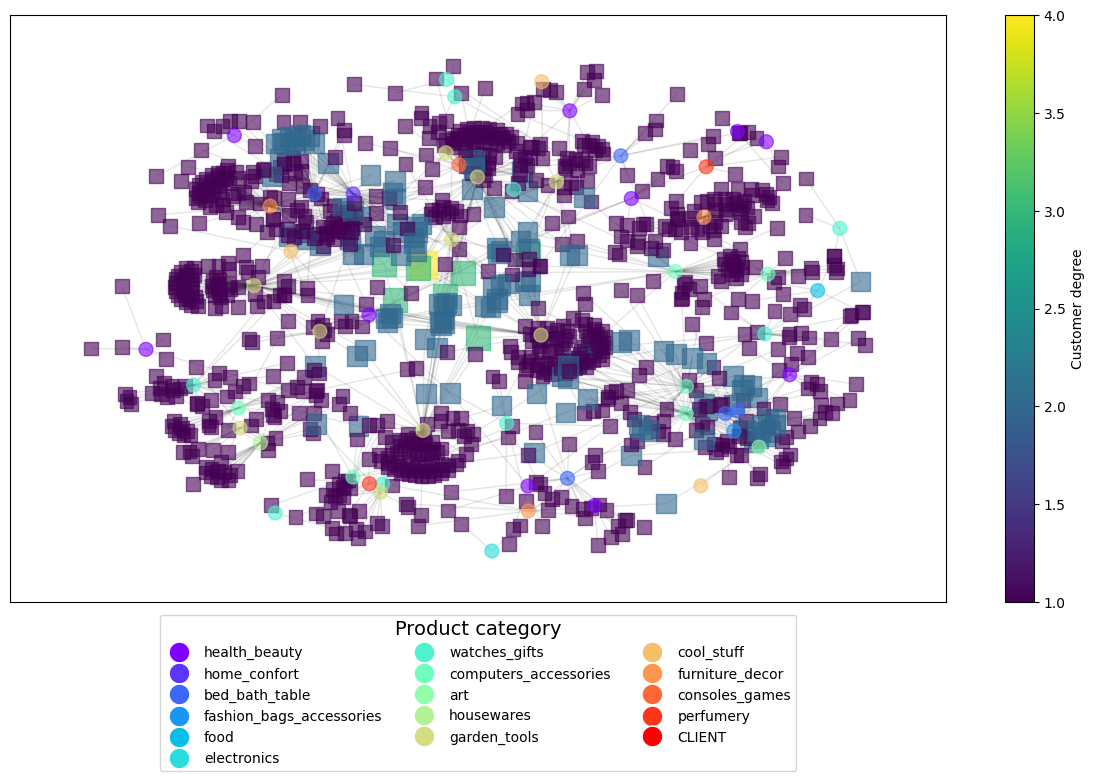

In [48]:
# DISPLAY GRAPH ###############################################################

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Plot the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=200)

product_nodes = [n for n in G.nodes if G.nodes[n]['bipartite'] == 'product']
customer_nodes = [n for n in G.nodes if G.nodes[n]['bipartite'] == 'customer']

product_categories = list(set(nx.get_node_attributes(G, 'category').values()))   



# Draw customer nodes --------
node_colors = [G.degree(n) for n in customer_nodes]
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
nx.draw_networkx_nodes(G, position, nodelist=customer_nodes, node_shape='s', node_size=100 * np.array(node_colors), node_color=node_colors, cmap='viridis', alpha=0.6)
plt.colorbar(sm, label='Customer degree')

# Draw product nodes --------
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
node_colors = [category_colors[G.nodes[n]['category']] for n in product_nodes if G.nodes[n]]

nx.draw_networkx_nodes(G, position, nodelist=product_nodes, node_shape='o', node_size=100, node_color=node_colors, alpha=0.6)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                     for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='lower center', title_fontsize=14, bbox_to_anchor=(0.5, -0.3), ncol=3)

# plot edges
nx.draw_networkx_edges(G, position, alpha=0.1)

plt.tight_layout()
plt.show()

### 2.2 Détection des Communautés


___ Community detection ___
Number of communities: 18
Communities sizes: 88, 86, 84, 78, 74, 73, 72, 58, 53, 44, ...


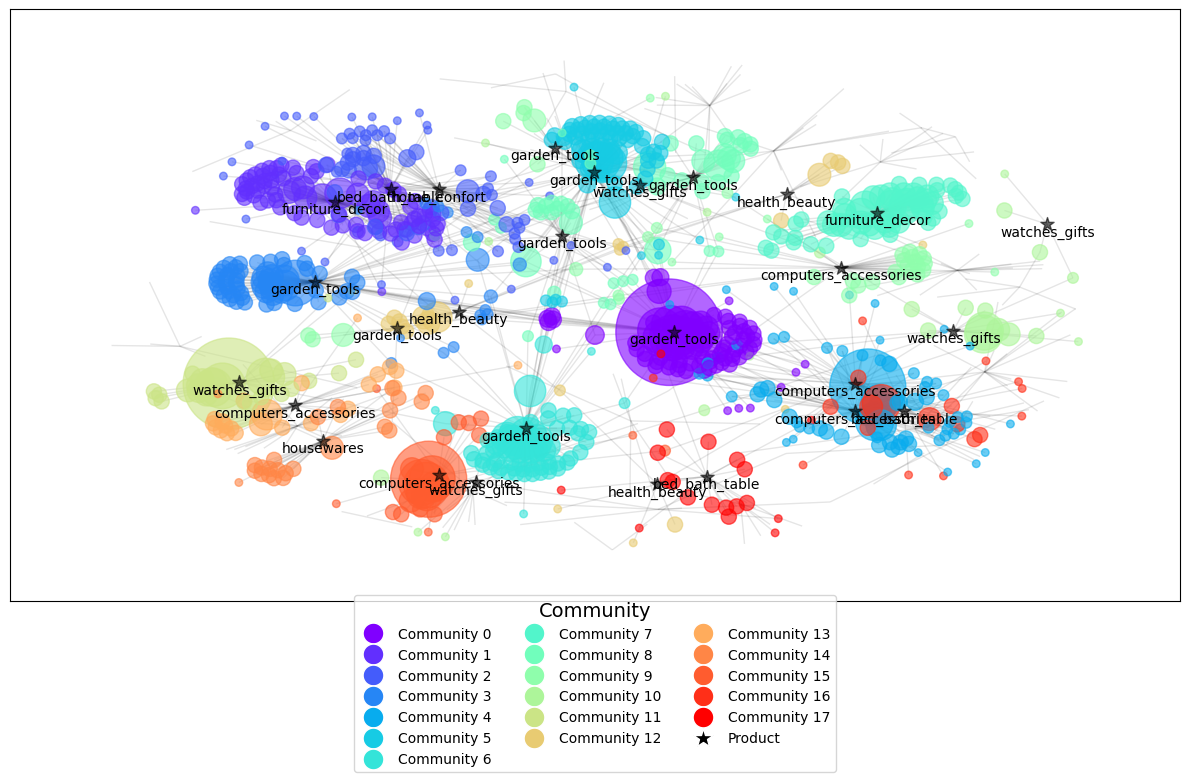

In [51]:
# COMMUNITY DETECTION #########################################################
communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')
communities = sorted(communities, key=len, reverse=True)
communities = [c for c in communities if len(c) >= 20]
print("\n___ Community detection ___")
print(f"Number of communities: {len(communities)}")
print(f"Communities sizes: {', '.join([str(len(c)) for c in communities[:10]])}, ...")

# Map each node to its community
node_community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_community_map[node] = i
        
# Plot communities distribution
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
community_colors = dict(zip(range(len(communities)), community_colors))
# Draw the graph
plt.figure(figsize=(12, 8))

# Draw edges --------
nx.draw_networkx_edges(G, position, alpha=0.1)

# Draw customer nodes --------
filtered_customer_nodes = [n for n in customer_nodes if n in node_community_map]
node_colors = [community_colors[node_community_map[n]] for n in filtered_customer_nodes]
# node_side = number of commands
nodes_edges = {n: sum([G.edges[n, p]['weight'] for p in G.neighbors(n)]) for n in filtered_customer_nodes}
node_sizes = [nodes_edges[n] * 30 for n in filtered_customer_nodes]
nx.draw_networkx_nodes(G, position, nodelist=filtered_customer_nodes, node_color=node_colors, node_size=node_sizes, alpha=0.6)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"Community {i}", markerfacecolor=color, markersize=15)
                        for i, color in community_colors.items()]

# Draw product nodes --------
filtered_product_nodes = [n for n in product_nodes if n in node_community_map]
nx.draw_networkx_nodes(G, position, nodelist=filtered_product_nodes, node_color="black", node_size=100, alpha=0.6, node_shape='*')
node_labels = {n: G.nodes[n]['category'] for n in filtered_product_nodes}
# Adjust label positions to avoid overlap
label_positions = {n: (x, y-0.03) for n, (x, y) in position.items()}
nx.draw_networkx_labels(G, label_positions, labels=node_labels, font_size=10)
legend_elements.append(plt.Line2D([0], [0], marker='*', color='w', label='Product', markerfacecolor='black', markersize=15))

plt.legend(handles=legend_elements, title="Community", loc='lower center', title_fontsize=14, bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.show()



Number of clusters: 5
Number of outliers: 138


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

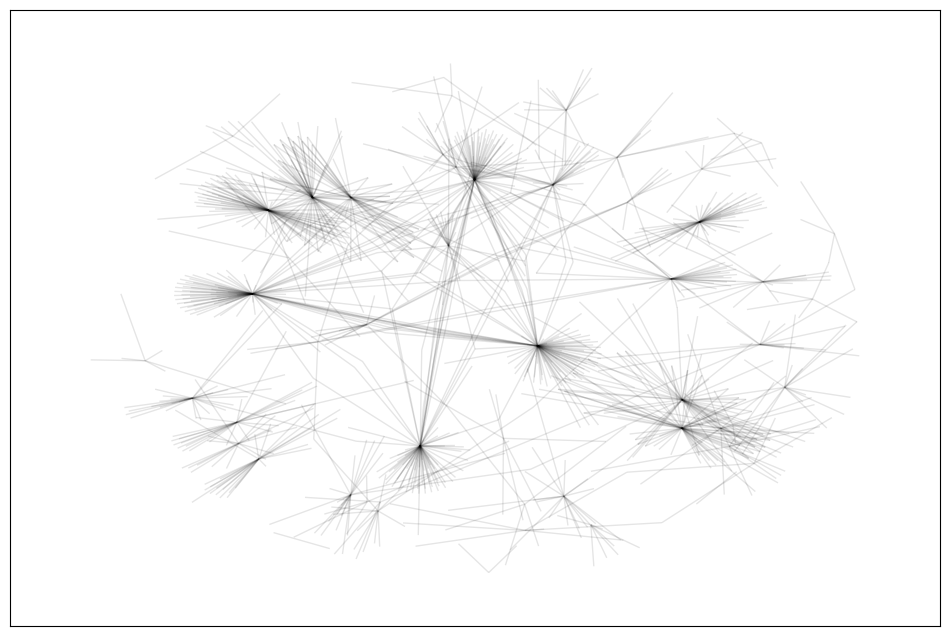

In [52]:
# DBSCAN CLUSTERING ###########################################################
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Prepare data
X = np.array([[G.degree(n), sum([G.edges[n, p]['weight'] for p in G.neighbors(n)])] for n in G.nodes])
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Clustering
dbscan = DBSCAN(eps=0.01, min_samples=30)
dbscan.fit(X)
labels = dbscan.labels_
print(f"Number of clusters: {len(set(labels))}")
print(f"Number of outliers: {sum(labels == -1)}")

# Plot clusters
plt.figure(figsize=(12, 8))
# Draw edges
nx.draw_networkx_edges(G, position, alpha=0.1)
# Draw customer nodes
filtered_customer_nodes = [n for n in customer_nodes if n in node_community_map]
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(labels))))
node_colors = [labels[filtered_customer_nodes.index(n)] for n in filtered_customer_nodes]
node_colors = [colors[l] if l != -1 else 'black' for l in labels[filtered_customer_nodes]]
nodes_edges = {n: sum([G.edges[n, p]['weight'] for p in G.neighbors(n)]) for n in filtered_customer_nodes}
node_sizes = [nodes_edges[n] * 10 for n in filtered_customer_nodes]
nx.draw_networkx_nodes(G, position, nodelist=filtered_customer_nodes, node_color=node_colors, node_size=node_sizes, cmap='viridis', alpha=0.6)

# Draw product nodes
filtered_product_nodes = [n for n in product_nodes if n in node_community_map]
nx.draw_networkx_nodes(G, position, nodelist=filtered_product_nodes, node_color="black", node_size=100, alpha=0.6, node_shape='*')
node_labels = {n: G.nodes[n]['category'] for n in filtered_product_nodes}
label_positions = {n: (x, y-0.03) for n, (x, y) in position.items()}
nx.draw_networkx_labels(G, label_positions, labels=node_labels, font_size=10)

plt.tight_layout()
plt.show()
